# Exercise 1

### Q: 

We consider a database containing six characterizing measurements for batches of plastic pellets. The outcome when using this material, either ”Poor” or ”Adequate”, is also provided. The goal is to classify material lots according to quality, starting from the measurements.

The dataset can be created with the following commands:
```
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dataframe = pd.read_csv(’https://openmv.net/file/raw-material-characterization.csv’)
data = dataframe.to_numpy()
A = data[:,2:].astype(np.float64)
labels = data[:,1]
groups = (’Adequate’, ’Poor’)
```
Each row of the matrix A refers to a sample (i.e. to a material lot). Each column corresponds to a feature.

The vector labels contains the material quality of the sample with corresponding index.

1. How many samples are there in the dataset? How many poor quality and adequate quality samples are there?
2. By exploiting the SVD decomposition, perform PCA on the provided data. Then, plot the trend of the singular
values σk in logarithmic scale.
3. Compute a matrix containing the principal components associated with the dataset.
4. Generate a scatterplot of the first two principal components of the dataset, grouped by label.
5. Propose a simple classifier to discriminate among poor and adequate quality materials, based on the second principal component. Then compute the accuracy of the classifier (i.e. the fraction of correctly classified
samples).

### A:

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dataframe = pd.read_csv('https://openmv.net/file/raw-material-characterization.csv')
data = dataframe.to_numpy()
A = data[:,2:].astype(np.float64)
labels = data[:,1]
groups = ('Adequate', 'Poor')

1. How many samples are there in the dataset? How many poor quality and adequate quality samples are there?

In [148]:
# visualize the initial dataset
dataframe.head()

,Lot number,Outcome,Size5,Size10,Size15,TGA,DSC,TMA
0,B370,Adequate,13.8,9.2,41.2,787.3,18.0,65.0
1,B880,Adequate,11.2,5.8,27.6,772.2,17.7,68.8
2,B452,Adequate,9.9,5.8,28.3,602.3,18.3,50.7
3,B287,Adequate,10.4,4.0,24.7,677.9,17.7,56.5
4,B576,Adequate,12.3,9.3,22.0,593.5,19.5,52.0


In [149]:
adequate_indexes = [i for i in range(len(labels)) if labels[i]==groups[0]]
poor_indexes = [i for i in range(len(labels)) if labels[i]==groups[1]]

print('The dataset presents ', A.shape[0], ' samples and ', A.shape[1], ' features')
print('The dataset presents ', len(adequate_indexes), ' adequate quality samples')
print('The dataset presents ', len(poor_indexes), ' poor quality samples')


The dataset presents  24  samples and  6  features
The dataset presents  17  adequate quality samples
The dataset presents  7  poor quality samples


2. By exploiting the SVD decomposition, perform PCA on the provided data. Then, plot the trend of the singular
values σk in logarithmic scale.

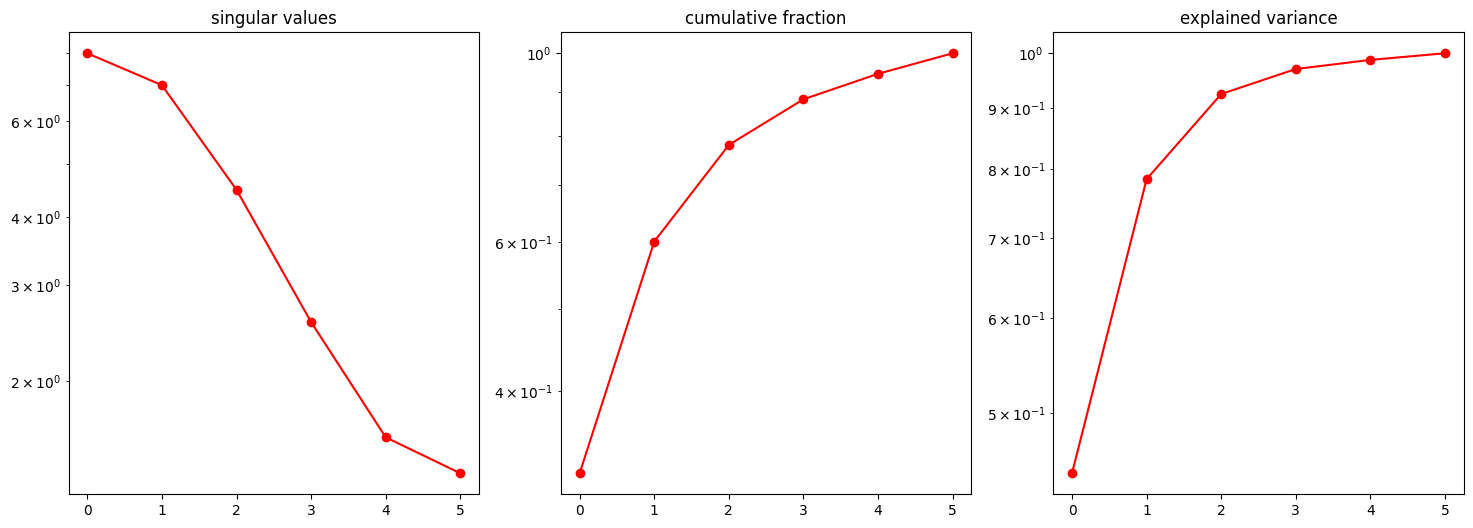

In [150]:
# center the data
A_mean = A.mean(axis=0)
A_centered = A - A_mean[None, :]

# Given that the data have different scales, we need should normalize it
A_centered /= np.std(A_centered, axis=0)

# perform SVD
U, s, VT = np.linalg.svd(A_centered)

# setup the plot
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))

# plot the singular values
axes[0].semilogy(s, 'o-', color = 'red')
axes[0].set_title('singular values')

# plot the cumulative fraction of singular values
axes[1].semilogy(np.cumsum(s)/np.sum(s), 'o-',  color = 'red')
axes[1].set_title('cumulative fraction')

# plot the explained variance
axes[2].semilogy(np.cumsum(s**2)/np.sum(s**2), 'o-',  color = 'red')
axes[2].set_title('explained variance')

# show the plot
plt.show()

3. Compute a matrix containing the principal components associated with the dataset.


In [151]:
# rows of VT are the principal components directions given that rows of A_centered are different samples
# if we were working with A.T, then the columns of U would be the principal components directions (apart from the sign)
Ut, _, _ = np.linalg.svd(A_centered.T, full_matrices=False)
for idx in range(len(Ut.T)):
	if np.sign(Ut.T[idx][0]) != np.sign(VT[idx][0]):
		Ut.T[idx] *= -1
assert np.allclose(VT, Ut.T)

# To obtain the principal componets with their respective weight we multiply by the associated singular values
Phi = VT @ np.diag(s)

4. Generate a scatterplot of the first two principal components of the dataset, grouped by label.

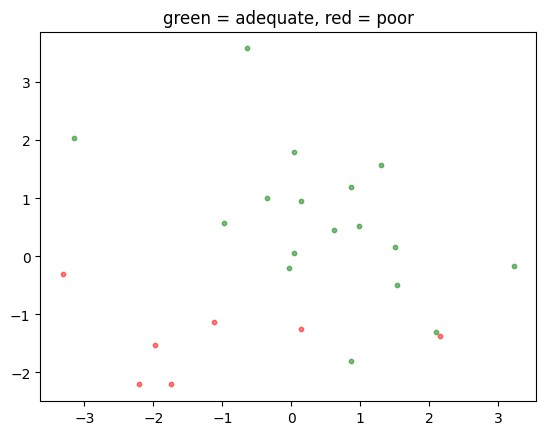

In [152]:
x = A_centered @ VT.T[:,0]
y = A_centered @ VT.T[:,1]

for i in range(len(A_centered)):
    if i in adequate_indexes:
        col = 'green'
    else:
        col = 'red'
    plt.scatter(x[i], y[i], marker='o', color=col, s=10, alpha=0.5)
plt.title('green = adequate, red = poor')
plt.show()

5. Propose a simple classifier to discriminate among poor and adequate quality materials, based on the second principal component. Then compute the accuracy of the classifier (i.e. the fraction of correctly classified
samples).

In [153]:
# define the simple classifier as a simple linear classifier in one dimension.
# The classifier is naive and obtained by directly looking at the plotted data.
# More rigourous approaches are possible such as implementing a linear regression
def simple_classifier(sample, VT):
    y = sample @ VT.T[:,1]
    if y < -0.75:
        return groups[1]
    return groups[0]

# evaluate the capabilities of the classifier
# note I assume that the test is positive if the materials are adequate
TP = 0
FP = 0
TN = 0
FN = 0
for i in range(len(A_centered)):
    pred = simple_classifier(A_centered[i], VT)
    if pred == groups[0]:
        if labels[i] == pred:
            TP += 1
        else:
            FP += 1
    else:
        if labels[i] == pred:
            TN += 1
        else:
            FN += 1

print('Recall: ', TP/(TP+FN))
print('Precision: ', TP/(TP + FP))
print('Accuracy: ', (TP+TN)/(TP+TN+FP+FN))

Recall:  0.8823529411764706
Precision:  0.9375
Accuracy:  0.875


# Exercise 2

### Q:

Consider the function
$ f (x) = f1 (x) + f2 (x) $

where $ f1 (x) = (x − 1)^2 and f2 (x) = (x + 1)^2 $.

Use the Stochastic Gradient Descent (SGD) method to find the minimum of f (x); each iteration of the SGD is
given by

$ x_k+1 = x_k − η_k ∇f_{i(k)} (x_k) $

where $ i(k) ∈ {1, 2} $ is drawn uniformly. 

Initialize the method with a random initial condition x0 and perform 5000 iterations; consider the following 
two choices for ηk :

- $ η_k = η = 10^{−3} $

- $ η_k = \frac{1}{10+k} $

Plot the convergence history in the two cases.
Find experimentally how the quantity $ E(f (x_k)) − f(x^∗) $ (where $x^∗ $ is the point where f (x) attains the minimum) depends on the number of performed iteration. Comment the result.

### A:


In [154]:
from tqdm.notebook import tqdm
import jax

np.random.seed(0)
# define the functions
def f1(x):
    return (x-1)**2
def f2(x):
    return (x+1)**2
def f(x):
    return f1(x) + f2(x)

def constant_eta(k):
    return 1e-3

def decreasing_eta(k):
    return 1/(10+k)

def SGD(eta, start_point, f, grads_jit, num_epochs=5000):
    x = start_point
    history = list()
    history.append(x)
    
    for epoch in tqdm(range(num_epochs)):
        idxs = np.random.choice(2, 1)[0]
        grad = grads_jit[idxs]
        x -= eta(epoch) * grad(x)
    
        history.append(x)
    return x, history

In [155]:
grads = [jax.jit(jax.grad(f1)), jax.jit(jax.grad(f2))]
start = np.random.randn()*100
x_fixed, history_fixed = SGD(constant_eta, start, f, grads)
x_variable, history_variable = SGD(decreasing_eta, start, f, grads)

print('Fixed learning rate: ', x_fixed)
print('Variable learning rate: ', x_variable)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fixed learning rate:  0.012758677
Variable learning rate:  -0.030768672


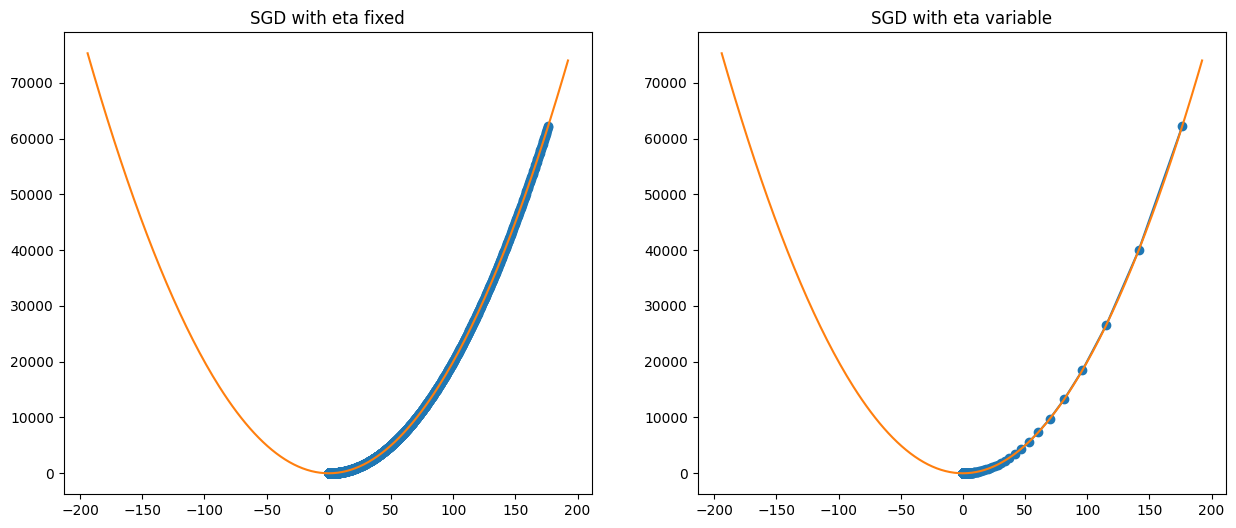

In [156]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
x = np.arange(-int(abs(start)*1.1),int(abs(start))*1.1,abs(start)/100)

values = []
for i in history_fixed:
    values.append(f(i))

axs[0].plot(history_fixed, values, 'o-')
axs[0].scatter(x_fixed, f(x_fixed), marker='*', color='orange')
axs[0].plot(x, f(x))
axs[0].set_title('SGD with eta fixed')

values = []
for i in history_variable:
    values.append(f(i))
axs[1].plot(history_variable, values, 'o-')
axs[1].scatter(x_variable, f(x_variable), marker='*', color='orange')
axs[1].plot(x, f(x))
axs[1].set_title('SGD with eta variable')
plt.show()

From the above graph we can notice how the minimum appears to be in $ x^*=0$.
The stochastic gradient descent with fixed eta slower in the beginning but faster in the later iterations. Having a dynamically decreasing learning rate bring many positives:
- At the beginning the learning rate is high allowing us to get near a minumum faster
- After a large number of iterations the decrease of eta allows a decrease in the intrinsic convergence error of SGD (wich is in fact dependant on the learning rate). This tell us that this function will thend to the exact minimum

Note that obtaining the exact minimum may not be always the best choice because it may cause overfitting so it do not translate in a real improvement of performances. However for the given application this is not the case.
Also a decreasing eta without a lower bound may cause the algoritm to stop learning and in many applications this is not a good scenario.

In the following I will try to analyze how $ E[f(x_k) - f(x^*)] $ varies from the obtained data.

In [157]:
# repeat the process to increase reliability of the results
n_iterations = 5
num_epochs = 5000
# optimum
minimum = f(0)

# history
mean_error_history_fixed = np.zeros((n_iterations, num_epochs+1))
mean_error_history_variable = np.zeros((n_iterations, num_epochs+1))

for i in range(n_iterations):
    start = np.random.randn()*100
    x_fixed, history_fixed = SGD(constant_eta, start, f, grads, num_epochs=num_epochs)
    values = []
    for el in history_fixed:
        values.append(f(el)-minimum)
    mean_error_history_fixed[i] = values 

    x_variable, history_variable = SGD(decreasing_eta, start, f, grads, num_epochs=num_epochs)
    values = []
    for el in history_variable:
        values.append(f(el)-minimum)
    mean_error_history_variable[i] = values

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [158]:
mean_error_history_variable.mean(axis=1)

array([2.17817667, 2.56083618, 0.16018945, 0.07634235, 0.26465668])

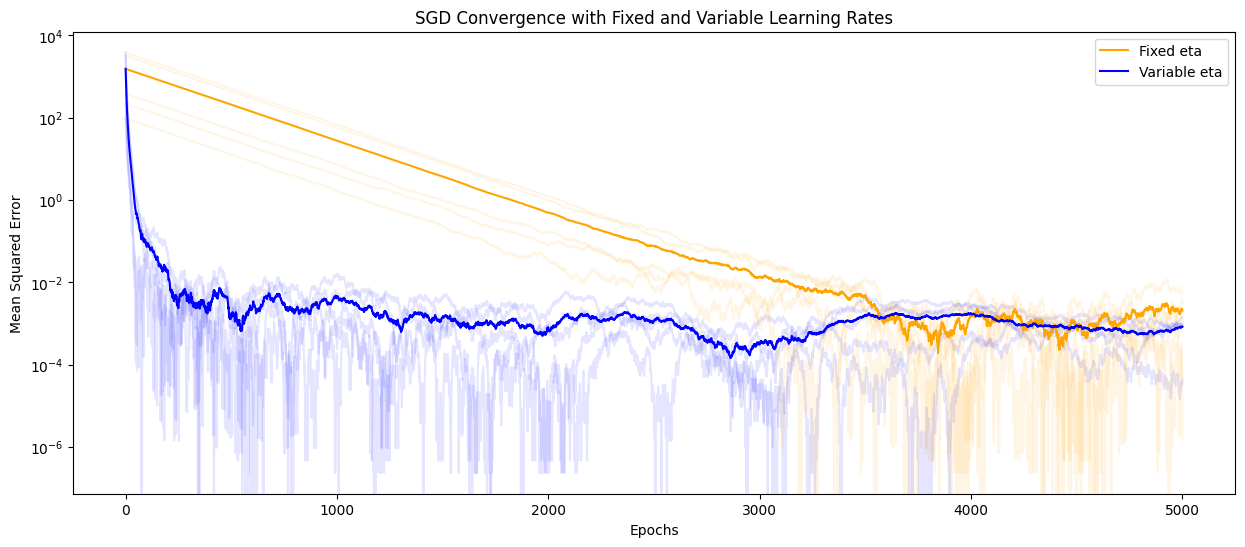

In [159]:
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
x = np.arange(num_epochs+1)

for i in range(n_iterations):
	sns.lineplot(x=x, y=mean_error_history_fixed[i], color='orange', alpha=0.1)
	sns.lineplot(x=x, y=mean_error_history_variable[i], color='blue', alpha=0.1)

mean_fixed = np.mean(mean_error_history_fixed, axis=0)
mean_variable = np.mean(mean_error_history_variable, axis=0)

sns.lineplot(x=x, y=mean_fixed, color='orange', label='Fixed eta')
sns.lineplot(x=x, y=mean_variable, color='blue', label='Variable eta')

axs.set_title('SGD Convergence with Fixed and Variable Learning Rates')
axs.set_xlabel('Epochs')
axs.set_ylabel('Mean Squared Error')
axs.set_yscale('log')
axs.legend()
plt.show()


The dinamic learning rate proves to be better than the fixed one basically for any number of ephocs. 
In particular we can see how in the beginning having a greater learing rate allow to reduce the expected error much faster. 
Then in the later stage of the training we see that an increasingly lower learning rate also allow to converge to a more 
precise result by reducing the intrinsic error of the SGD.

# Exercise 3

### Q:

Given an input x ∈ R2 , a weight vector w ∈ R2 and a bias b0 ∈ R, draw the computational graph for the computation of the mean squared error L = MSE(ŷ, y) of a prediction ŷ = σ(wT x + b0 ) with respect to the true value y; σ is the sigmoid function.

Consider the following values for x, w, b0 and y:

$x = \begin{bmatrix}1 \\ 1 \end{bmatrix} \ \ 
 w = \begin{bmatrix}4/5 \\ 7/5\end{bmatrix}\ \ 
 b_0=\frac{3}{5} \ \ 
 y = 1
$

and the MSE function $ L = (ŷ − y)^2$ . Report the correponding values on the computational graph.

Explain how the backpropagation method can be used to compute the gradient of L with respect to the inputs.

Draw the computational graph for the computation of the gradient and calculate the gradients values for each edge and node in the computational gradient graph.

### A:

![graph](./3_image.png)

Figure 1: Computational graph for the computation of the mean squared error v4 = L = MSE(ŷ, y) of a prediction ŷ = σ(wT x + b0 ) = v2 with respect to the true value y.

A computational graph is a directed acyclic graph (DAG) where:
- Nodes represent operations or functions (e.g., addition, multiplication, sigmoid).
- Edges represent the flow of data (variables or intermediate results) through the computation.

The computational graph can be exploited in the backpropagation algorithm to perform automatic differentiation in backward mode.
The backward mode of automatic differentiation requires:
1. a forward pass over the graph to compute it and the intermediate results of the variables.
2. a backward pass over the graph to compute the gradients on the edges of the term on top with respect to the ones on the bottom.
   By doing so, from the output towards the inputs, we find all path from the root to the input allowing us to compute gradients using the chain rule.

The classig backpropagation algorithm is just a simplified and closed version of this procedure that exploit the fact that all outputs of a layer are based on the output of the previous one. 
This means that the path of the deeper layer is the path of the narrower unified by the path between the two. So the results from the outer layer are reused for the deeper ones incrementally.


#### Note:
It is important to note that in the specified exercise we are required to compute the gradient of the loss with respect to the input. This is not a common operation in the backpropagation algorithm because it is not a common operation in the training of a neural network. 
Usually, the gradient is computed with respect to the weights and biases of the network. However, the backpropagation algorithm can be used to compute the gradient of the loss with respect to the input by following the same procedure as for the weights and biases.

As we can see from the image the intermediate result of the graph are the following:
- $ \frac{\partial{L}}{\partial{error}} = 2error = 2(0,9427) = -0.11$     where error is y_pred - y
- $ \frac{\partial{error}}{\partial{out}} = 1 $      $out = \sigma(z) $
- $ \frac{\partial{out}}{\partial{z}} = 1 - \sigma(z) =  \sigma(z)(1 - \sigma(\frac{14}{5})) = 0.054$
- $ \frac{\partial{z}}{\partial{prod}} = 1 $      where prod = wTx
- $ \frac{\partial{prod}}{\partial{x}} =  w = \begin{bmatrix}4/5 \\ 7/5\end{bmatrix} $


